In [43]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [44]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [46]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.359990
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ 

*For now, the probability that correct class has the highest score is close to o.1.*

*loss of softmax put -log() to the value.* 



In [53]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.159573 analytic: 2.159573, relative error: 8.807517e-09
numerical: 1.865541 analytic: 1.865541, relative error: 4.584611e-08
numerical: 1.449025 analytic: 1.449025, relative error: 1.571977e-08
numerical: 0.052045 analytic: 0.052045, relative error: 6.546523e-07
numerical: -0.197390 analytic: -0.197390, relative error: 3.377493e-08
numerical: 4.991188 analytic: 4.991188, relative error: 3.153453e-08
numerical: 0.230371 analytic: 0.230370, relative error: 4.407295e-07
numerical: 1.117874 analytic: 1.117874, relative error: 6.295663e-08
numerical: 0.388552 analytic: 0.388552, relative error: 3.611951e-08
numerical: -0.652925 analytic: -0.652925, relative error: 4.593531e-08
numerical: -0.712145 analytic: -0.712145, relative error: 1.147391e-07
numerical: -1.372220 analytic: -1.372220, relative error: 3.251166e-08
numerical: -5.906018 analytic: -5.906018, relative error: 3.515139e-09
numerical: -2.238735 analytic: -2.238735, relative error: 2.792215e-08
numerical: 1.984535 an

In [65]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.359990e+00 computed in 0.127810s
vectorized loss: 2.359990e+00 computed in 0.012595s
Loss difference: 0.000000
Gradient difference: 0.000000


In [68]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the softmax; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1.5e-7, 3.5e-7]
regularization_strengths = [2.3e4, 2.7e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


num_iters = 500
#from cs231n.classifiers import Softmax
learning_len = 10
regularization_len = 10

learning_rates_list = np.linspace(learning_rates[0], learning_rates[1], learning_len)
regularization_strengths_list = np.linspace(regularization_strengths[0], regularization_strengths[1], regularization_len)

for learning_idx ,learning_rate in enumerate(learning_rates_list):
  for regularization_idx, regularization_strength in enumerate(regularization_strengths_list):
    # initialize new Softmax object
    print("{} out of {}".format((learning_idx+1,regularization_idx+1), (learning_len,regularization_len)))
    softmax = Softmax()
    
    #train it with given hyperparameters
    softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                        num_iters=num_iters, verbose=True)
    
    # predict with the trained softmax, then calculate accuracy
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    
    # add result to results
    result_key = (learning_rate, regularization_strength)
    
    (training_accuracy, validation_accuracy) = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
    result_value = (training_accuracy, validation_accuracy)
    
    results[result_key] = result_value

    # find the best softmax with the highest validation accuracy
    if best_val < validation_accuracy:
      best_softmax = softmax
      best_val = validation_accuracy

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(1, 1) out of (10, 10)
iteration 0 / 500: loss 717.215017
iteration 100 / 500: loss 180.090873
iteration 200 / 500: loss 46.448731
iteration 300 / 500: loss 13.118505
iteration 400 / 500: loss 4.838897
(1, 2) out of (10, 10)
iteration 0 / 500: loss 730.923699
iteration 100 / 500: loss 178.830864
iteration 200 / 500: loss 45.031989
iteration 300 / 500: loss 12.532372
iteration 400 / 500: loss 4.625790
(1, 3) out of (10, 10)
iteration 0 / 500: loss 734.363847
iteration 100 / 500: loss 174.851965
iteration 200 / 500: loss 42.912149
iteration 300 / 500: loss 11.703879
iteration 400 / 500: loss 4.390250
(1, 4) out of (10, 10)
iteration 0 / 500: loss 768.871244
iteration 100 / 500: loss 177.805875
iteration 200 / 500: loss 42.509876
iteration 300 / 500: loss 11.413319
iteration 400 / 500: loss 4.261085
(1, 5) out of (10, 10)
iteration 0 / 500: loss 762.727480
iteration 100 / 500: loss 172.157416
iteration 200 / 500: loss 40.230456
iteration 300 / 500: loss 10.594466
iteration 400 / 500: loss

In [69]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.354000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ *True*



$\color{blue}{\textit Your Explanation:}$

*For SVM classifer, adding appropriate datapoint which has high score on one class and low class on others, will be maxed-out by max function. This means loss will not be changed.*

*For Softmax classifer, for any data point, probability cannot be 1 because it sums the exp values of score. This means loss will be changed.*

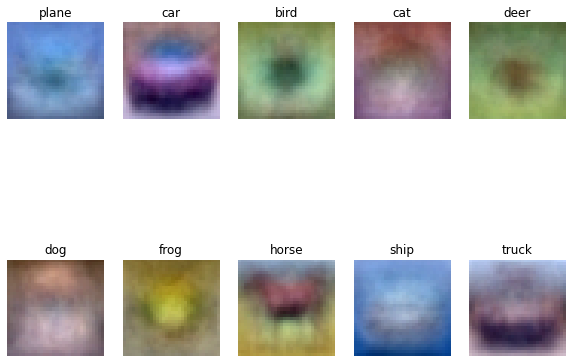

In [70]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])